Crypto Portfolio Risk Management

Download two-year of prices and other useful data (from 2020-2-1 to 2022-2-1) from Yahoo Finance 
for the following 4 cryptocurrencies (They are among the crypto assets with the highest trading 
volume
Symbols: BTC-USD, ETH-USD, DOGE-USD, MATIC-USD

In [1]:
# %pip install tabulate
# %pip install PyPortfolioOpt

In [2]:
import numpy as np
import pandas as pd
from IPython.display import display
from copy import deepcopy
from math import sqrt, exp
import datetime as dt
from datetime import datetime, date
import yfinance as yf
from functools import reduce
import scipy.stats as si
import sympy as sy
from scipy.stats import norm, binom, levy_stable
from scipy.optimize import minimize
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from pypfopt import expected_returns
from pypfopt import risk_models
from pypfopt import EfficientFrontier
import cvxpy as cvx
pd.reset_option("display.max_rows")
%matplotlib inline

In [3]:
from pandas_datareader._utils import RemoteDataError

#Create helper function to retrieve stock/crypto data from yahoo finance
def get_data_for_multiple_crypto(tickers,start_date='2020-02-01',end_date= '2022-02-01'):
    #define helper function here
    stocks = dict()
    # loop through all the tickers
    for ticker in tickers: 
        format='%Y-%m-%d'
        try:
            s = yf.download(ticker, dt.datetime.strptime(start_date, format), dt.datetime.strptime(end_date, format))
        except RemoteDataError:
            print(f"Failed to download data for {ticker} from Yahoo Finance. Loading data from CSV file.")
            s = get_data_for_multiple_stocks_csv([ticker])[ticker]
        
        s.insert(0, "Ticker", ticker)  #insert ticker column so you can reference better later
        
        # Calculate and store the log returns
        s['Prev Close'] = s['Adj Close'].shift(1)
        s['log_return'] = np.log(s['Adj Close']/s['Prev Close'])
        s['perc_return'] = (s['Adj Close']/s['Prev Close']) - 1
        # add it to the dictionary
        stocks[ticker] = s.reset_index()
    # return the dictionary
    return stocks

def get_data_for_multiple_stocks(tickers, start_date, end_date):
    '''
    Function that uses Pandas DataReader to download data directly from Yahoo Finance,
    computes the Log Returns series for each ticker, and returns a DataFrame 
    containing the Log Returns of all specified tickers.
    
    Parameters:
    - tickers (list): List of Stock Tickers.
    - start_date, end_date (str): Start and end dates in the format 'YYYY-MM-DD'.
    
    Returns:
    - returns_df (pd.DataFrame): A DataFrame with dates as indexes, and columns corresponding
                                 to the log returns series of each ticker.
    '''

    # initialise output dataframe
    returns_df = pd.DataFrame()
    
    for ticker in tickers:
        # retrieve stock data (includes Date, OHLC, Volume, Adjusted Close)
        format='%Y-%m-%d'
        s = yf.download(ticker, dt.datetime.strptime(start_date, format), dt.datetime.strptime(end_date, format))
        # calculate log returns
        s['Log Returns'] = np.log(s['Adj Close']/s['Adj Close'].shift(1))
        # append to returns_df
        returns_df[ticker] = s['Log Returns']
        
    # skip the first row (that will be NA)
    # and fill other NA values by 0 in case there are trading halts on specific days
    returns_df = returns_df.iloc[1:].fillna(0)
        
    return returns_df


def get_data_for_multiple_stocks2(tickers, start_date, end_date):
    # initialise output dataframe
    returns_df = pd.DataFrame()

    for ticker in tickers:
        format='%Y-%m-%d'
        s = yf.download(ticker, dt.datetime.strptime(start_date, format), dt.datetime.strptime(end_date, format))

        returns_df[ticker] = s['Adj Close']

    returns_df = returns_df.iloc[1:].fillna(0)

    return returns_df


# Basic analysis and visualizations of the portfolio

Retrieve the daily prices of the 4 cryptos online (2020-2-1 to 2022-2-1) and calculate the daily 
log returns. 

In [4]:
# Get Data for BTC, ETH, DOGE, and MATIC
coins = get_data_for_multiple_crypto(
    ["BTC-USD","ETH-USD","DOGE-USD","MATIC-USD"])

btc = coins["BTC-USD"]
eth = coins["ETH-USD"]
doge = coins["DOGE-USD"]
matic = coins["MATIC-USD"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
# Create a dataframe with the log_returns of each coin
log_returns = pd.DataFrame()
log_returns["Date"] = btc["Date"]
for coin, data in coins.items():
  log_returns[coin] = data['log_return']
# set the index of the dataframe to be the date column (if there is one)
log_returns.set_index('Date', inplace=True)

<Figure size 1800x1000 with 0 Axes>

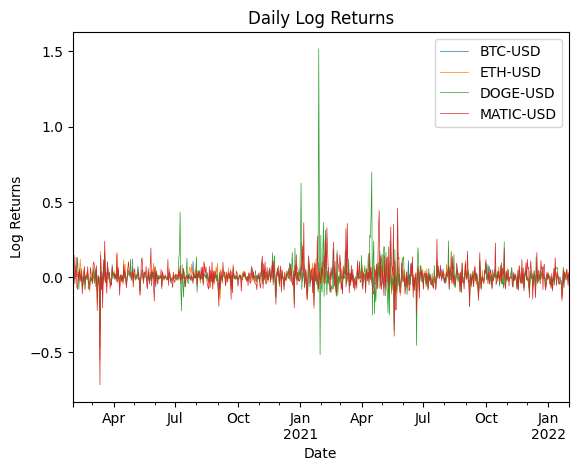

In [6]:
# create the line plot
plt.figure(figsize=(18, 10))
log_returns.plot(kind='line', linewidth=0.5)

# set the title and axis labels
plt.title('Daily Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Returns')



# show the plot
plt.show()

Plot the asset return correlations using a matrix heatmap, and plot the annualized 
Sharpe ratios of the four crypto assets using a bar chat.

             BTC-USD    ETH-USD    DOGE-USD    MATIC-USD
---------  ---------  ---------  ----------  -----------
BTC-USD         1.00       0.82        0.42         0.61
ETH-USD         0.82       1.00        0.39         0.67
DOGE-USD        0.42       0.39        1.00         0.28
MATIC-USD       0.61       0.67        0.28         1.00


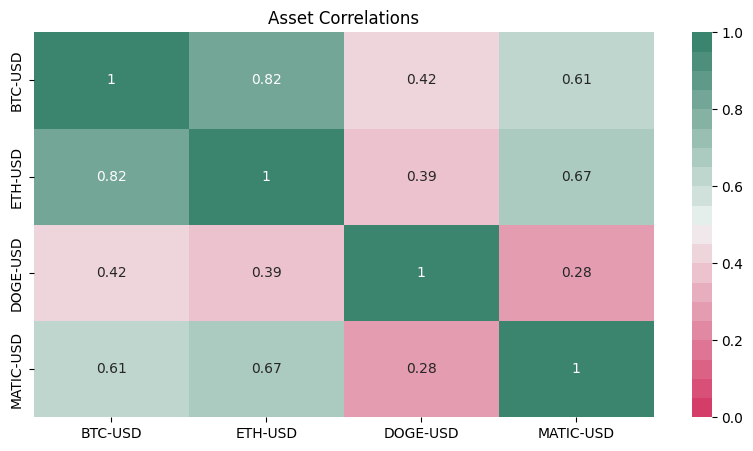

In [7]:
# Calculate the asset correlation
corr = round(log_returns.corr(), 2)
print(tabulate(corr, headers = corr.columns, showindex = True, floatfmt = '.2f'))

# Plot the asset correlation using a matrix heat map
plt.figure(figsize = (10,5))
sns.heatmap(corr, cmap = sns.diverging_palette(0, 160, n = 20), annot = True, vmin = 0, vmax = 1)
plt.title("Asset Correlations")
plt.show()

In [8]:
log_returns["BTC-USD"].mean(axis = 0)

0.0019318745347634816

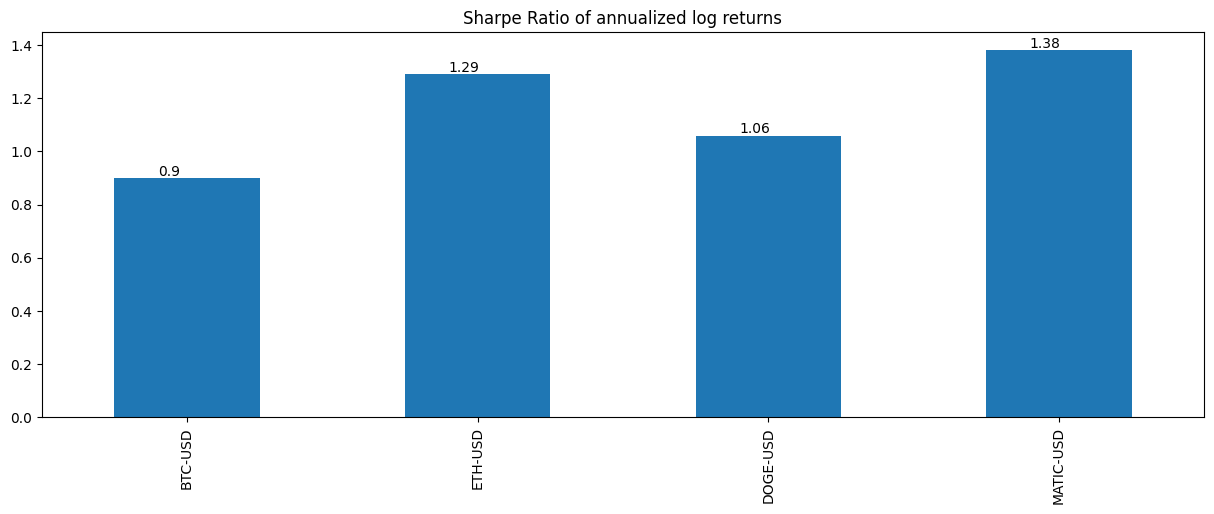

In [9]:
# calculate Sharpe Ratio, and annualize it by multiplying sqrt(365) 
# as crypto is traded on every day of the year
ax = round(log_returns.mean(axis = 0) / log_returns.std(axis = 0) * 365 ** 0.5, 2).plot(kind="bar", figsize = (15, 5))
plt.title("Sharpe Ratio of annualized log returns")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, p.get_height() + 0.01))

**Observations**  
The cryptocurrencies experienced high volatility, and that the log returns of DOGE-USD are much higher and more volatile than the other three cryptocurrencies.

From the correlation matrix,  BTC-USD and ETH-USD have a strong positive correlation of 0.82, which suggests that they tend to move in the same direction. The other correlations are weaker, with DOGE-USD and MATIC-USD having the lowest correlation of 0.28.

# Markowitz MVO and simulated portfolio value

Assuming we are long only, with total weights equal to 1, run a Mean-Variance Optimization on 
the crypto assets to minimize risk. Plot the resultant holding weights for two constraint settings, 
one with the maximum holding weight limit to 0.5, and one with no limit on maximum holding 
weight. So you will have two graphs, each has 4 lines of different colors. Each line has 731 
values between 0-1, representing the holding weight for that asset on each day. 

In [10]:
assets = ["BTC-USD","ETH-USD","DOGE-USD","MATIC-USD"]
combine_df = get_data_for_multiple_stocks(
    assets, start_date = '2019-10-23', end_date = '2022-02-01')
copy = combine_df.copy()
simple_returns = np.exp(copy) -1
print(combine_df)
print(simple_returns)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
             BTC-USD   ETH-USD  DOGE-USD  MATIC-USD
Date                                               
2019-10-24 -0.002823 -0.001443  0.017088   0.023520
2019-10-25  0.144761  0.112747  0.055932   0.056279
2019-10-26  0.065284 -0.009341 -0.023371  -0.059743
2019-10-27  0.032641  0.024209  0.012131   0.039939
2019-10-28 -0.031433 -0.008609 -0.003019   0.002055
...              ...       ...       ...        ...
2022-01-27  0.007734 -0.018413 -0.017837   0.000395
2022-01-28  0.017248  0.049945  0.002891   0.053536
2022-01-29  0.009321  0.019437  0.009835   0.009334
2022-01-30 -0.005800  0.002454 -0.025380  -0.054332
2022-01-31  0.014804  0.032057  0.016596   0.023755

[831 rows x 4 columns]
             BTC-USD   E

In [11]:
prices_df = get_data_for_multiple_stocks2(assets, start_date = '2019-10-23', end_date = '2022-02-01')
prices_df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,BTC-USD,ETH-USD,DOGE-USD,MATIC-USD
Date,,,,
2019-10-24,7493.488770,162.168549,0.002538,0.013594
2019-10-25,8660.700195,181.523209,0.002684,0.014381
2019-10-26,9244.972656,179.835480,0.002622,0.013547
2019-10-27,9551.714844,184.242218,0.002654,0.014099
2019-10-28,9256.148438,182.662811,0.002646,0.014128
...,...,...,...,...
2022-01-27,37138.234375,2423.001221,0.141247,1.591683
2022-01-28,37784.332031,2547.092041,0.141656,1.679217
2022-01-29,38138.179688,2597.084717,0.143056,1.694964


In [12]:
window_size = 100

**Rationale for window scale**  
Window size -> 100 ([MA, SMA, EMA, WMA: A Complete Guide for Traders Explained by GC](https://goodcrypto.app/moving-averages-sma-ema-wma-a-complete-guide-for-traders-explained-by-good-crypto/#:~:text=The%20most%20significant%20cross%20that,is%20called%20a%20Golden%20Cross.)) most common is 50, 100 and 200. We chose 100 to balance between maintaining long term outlook and short term volatility


In [13]:
def get_optimized_portfolio(returns_df, returns_scale = .0001, max_holding = 0.5):
    """
    Function that takes in the returns series of assets, minimizes the utility function, 
    and returns the portfolio weights
    
    Parameters
    ----------
    returns_df : pd.dataframe
        Dataframe containing log asset return series in each column
    
    returns_scale : float
        The scaling factor applied to the returns
        
    max_holding : float
        The maximum weight a stock can hold.
        
    Returns
    -------
    x : np.ndarray
        A numpy ndarray containing the weights of the assets in the optimized portfolio
    """
    
    # convert returns dataframe to numpy array
    returns = returns_df.T.to_numpy()
    # m is the number of assets
    m = returns.shape[0]
  
    # covariance matrix of returns
    cov = np.cov(returns)
    
    # creating variable of weights to optimize
    # using the cvxpy package here
    x = cvx.Variable(m)
    
    # portfolio variance, in quadratic form
    portfolio_variance = cvx.quad_form(x, cov)
    # print("return in simple returns")
    # print(returns_df)
    log_returns_df = np.log(returns_df+1) # why + 1
    # print("return in log returns")
    # print(log_returns_df)
    total_return_log = log_returns_df.sum().to_numpy() #this is in log space, change to simple return
    # print("total return in log")
    # print(total_return_log)
    # print("total simple return")

    total_simple_return = np.exp(total_return_log) -1
    print(total_simple_return)
    frequency = 252 #assume daily compounding, we are going to take geometric average
    #this is the standard basic mean for optimization (to assume daily compounding)
    
    horizon_length = returns.shape[1]
    expected_mean = (1 + total_simple_return) ** (1 / horizon_length) - 1
    # print("geometric return")
    # print(expected_mean)
    #let's assume 
    # element wise multiplication, followed up by sum of weights
    portfolio_return = sum(cvx.multiply(expected_mean, x))
    
    # Objective Function
    # We want to minimize variance and maximize returns. We can also minimize the negative of returns.
    # Therefore, variance has to be a positive and returns have to be a negative.
    
    ### Interpretation of the returns_scale ###
    # For us to minimize returns, this function is trying to find the best values 
    # achieve the objective
    # when the return_scale is 0, its only is to minimize returns
    # means we are not looking to earn anything
    objective = cvx.Minimize(portfolio_variance - returns_scale * portfolio_return)
    
    # Constraints
    # long only, sum of weights equal to 1, no allocation to a single stock great than 50% of portfolio
    constraints = [x >= 0, sum(x) == 1, x <= max_holding]

    # use cvxpy to solve the objective
    problem = cvx.Problem(objective, constraints)
    # retrieve the weights of the optimized portfolio
    result = problem.solve()
    
    return x.value

**Rationale for returns_Scale**  
returns_scale -> 0.0001 (we want to minimize risk but still take into account returns)  
Maybe later check when `returns_scale = 0.04` to compare and see which number is more appropriate

In [14]:
def get_holding_weights(simple_returns, window_size, limit):
    holding_weight_df = pd.DataFrame(index=pd.date_range(start='2020-02-01', end='2022-02-01'), columns=assets)
    for i in range(len(simple_returns) - window_size):
        end_index = i + window_size
        window = simple_returns.iloc[i:end_index]
        portfolio = get_optimized_portfolio(window, 0.0001, limit)
        weights = pd.Series(portfolio)
        holding_weight_df.loc[holding_weight_df.index[i], assets] = weights.tolist()
        print(holding_weight_df.index[i])
    return holding_weight_df

no_limit_df = get_holding_weights(simple_returns, window_size, 1)
limit_df = get_holding_weights(simple_returns, window_size, 0.5)

[ 0.24430307  0.10934163 -0.0404809   0.35020338]
2020-02-01 00:00:00
[ 0.25347155  0.13261142 -0.04570526  0.34846263]
2020-02-02 00:00:00
[ 0.07893877  0.03908222 -0.08047691  0.32918429]
2020-02-03 00:00:00
[ 0.00525138  0.0557709  -0.06941266  0.63032412]
2020-02-04 00:00:00
[-0.03881522  0.02718366 -0.05689525  0.49861685]
2020-02-05 00:00:00
[ 0.03859871  0.11807236 -0.02418737  0.51705834]
2020-02-06 00:00:00
[ 0.03204543  0.11556272 -0.0007533   0.73665155]
2020-02-07 00:00:00
[0.06411409 0.20593125 0.05848624 0.70442399]
2020-02-08 00:00:00
[0.07234394 0.21297088 0.20803067 0.55243263]
2020-02-09 00:00:00
[0.09238308 0.24247811 0.22889731 0.59036484]
2020-02-10 00:00:00
[0.05704125 0.21528792 0.13665776 0.58753953]
2020-02-11 00:00:00
[0.1053432  0.29286651 0.15320441 0.67965811]
2020-02-12 00:00:00
[0.09704451 0.42419496 0.18324403 0.59047022]
2020-02-13 00:00:00
[0.09332084 0.41623528 0.15320124 0.5094289 ]
2020-02-14 00:00:00
[0.10161826 0.48343755 0.19101982 0.60337938]
20

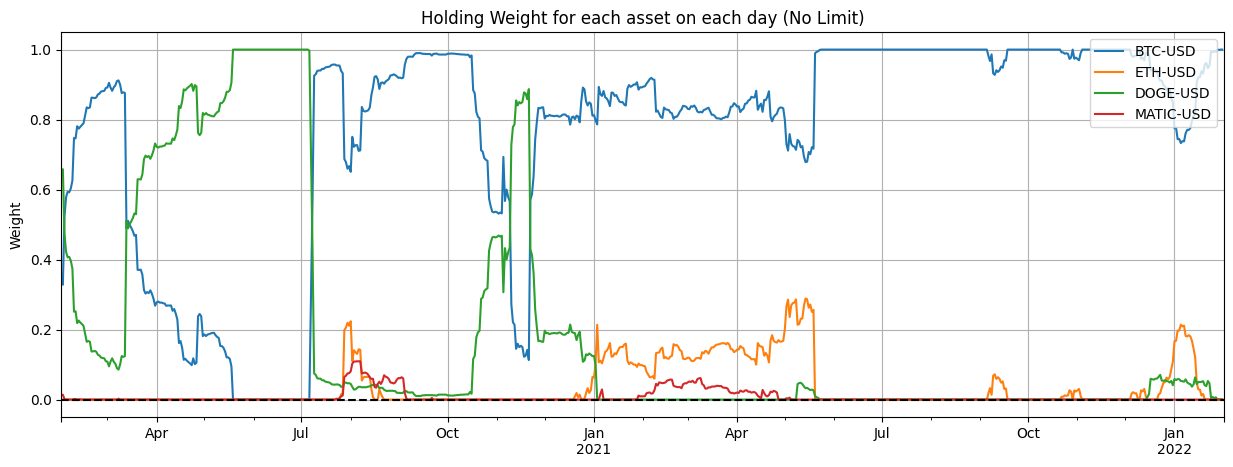

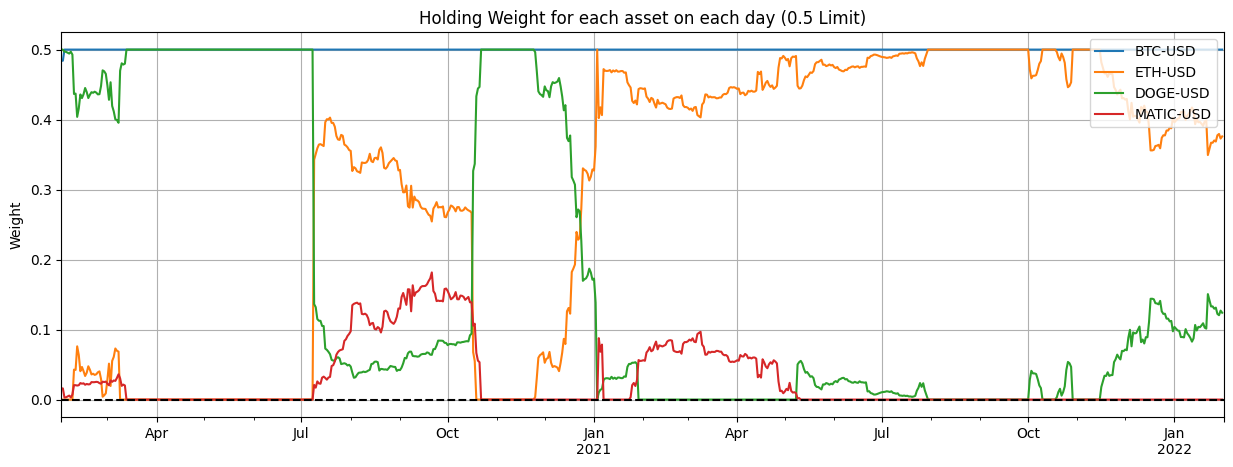

In [15]:
def holding_weight_plot(df, limit_str):
    df = df.loc['2020-02-01': '2022-02-01'] # locating the desired dates we want
    df.plot(figsize=(15,5))
    plt.title(f"Holding Weight for each asset on each day ({limit_str})")
    plt.ylabel("Weight")
    plt.axhline(y=0, color='black', linestyle='--')
    plt.grid()
    plt.legend(loc='upper right')
    plt.show()
    
holding_weight_plot(no_limit_df, 'No Limit')
holding_weight_plot(limit_df, '0.5 Limit')

In [16]:
### Preprocessing for the cumulative graphs ###

no_limit_df = no_limit_df.loc['2020-02-01': '2022-01-31']
limit_df = limit_df.loc['2020-02-01': '2022-01-31']
simple_returns = simple_returns.loc['2020-02-01': '2022-01-31']

In [17]:
straddle_df = no_limit_df.copy()
straddle_df

,BTC-USD,ETH-USD,DOGE-USD,MATIC-USD
2020-02-01,0.330609,0.0,0.655712,0.013679
2020-02-02,0.328128,0.0,0.658097,0.013775
2020-02-03,0.522288,-0.0,0.476095,0.001617
2020-02-04,0.578006,-0.0,0.421994,-0.0
2020-02-05,0.593596,-0.0,0.406404,-0.0
...,...,...,...,...
2022-01-27,0.993526,-0.0,0.006474,-0.0
2022-01-28,1.0,-0.0,-0.0,0.0
2022-01-29,0.999123,-0.0,0.000877,-0.0
2022-01-30,1.000004,-0.000017,0.000011,0.000003


Report the annualized returns and volatilities for the two portfolio settings and compare the 
results. 

In [18]:
amt_invested = 100000
earnings = ['BTC_Earnings', 'ETH_Earnings', 'DOGE_Earnings', 'MATIC_Earnings'] # column names for all the earnings value

def cumulative_earnings(holdingweight_df, simplereturn_df, column_names, amt_invested):
    curr_amt= amt_invested # current amount invested in the portfolio
    # Loop through each day in the data
    for i in range(len(holdingweight_df)):
        weights = holdingweight_df.loc[holdingweight_df.index[i], assets].values # locating the weights for the current day
        returns = simplereturn_df.iloc[i].values # locating the simple returns for the current day
        holdingweight_df.loc[holdingweight_df.index[i], column_names] = weights * returns * curr_amt # assigning the calculated earnings to the respective column in the earnings variable
        weighted_sr = weights * returns
        holdingweight_df.loc[holdingweight_df.index[i], 'weighted_sr'] = weighted_sr.sum()
        # Recalculating the current amount invested in the portfolio with sum of the earnings plus previous loop amout invested
        curr_amt = holdingweight_df.loc[holdingweight_df.index[i], column_names].values.sum() + curr_amt
    return holdingweight_df

no_limit_df = cumulative_earnings(no_limit_df, simple_returns, earnings, amt_invested)
limit_df = cumulative_earnings(limit_df, simple_returns, earnings, amt_invested)

no_limit_df['weighted_logreturn'] = np.log(no_limit_df['weighted_sr'] + 1)
limit_df['weighted_logreturn'] = np.log(limit_df['weighted_sr'] + 1)

no_limit_df['Portfolio'] = no_limit_df[earnings].sum(axis=1)
limit_df['Portfolio'] = limit_df[earnings].sum(axis=1)

no_limit_df['Portfolio_value'] = amt_invested + no_limit_df['Portfolio'].expanding(0).apply(lambda row : np.sum(row), raw=True)
limit_df['Portfolio_value'] = amt_invested + limit_df['Portfolio'].expanding(0).apply(lambda row : np.sum(row), raw=True)
annualized_return_no_limit = (no_limit_df['Portfolio_value'][-1] / no_limit_df['Portfolio_value'][0]) ** (1/2) - 1
annualized_return_limit = (limit_df['Portfolio_value'][-1] / limit_df['Portfolio_value'][0]) ** (1/2) - 1

print('Annnualized returns', annualized_return_no_limit)
print('Annnualized returns', annualized_return_limit)

no_limit_annualized_vol = round(no_limit_df['weighted_sr'].std() * np.sqrt(365), 2)
limit_annualized_vol = round(limit_df['weighted_sr'].std() * np.sqrt(365), 2)

print(f'No Limit Annualized Volatility: {no_limit_annualized_vol}')
print(f'0.5 Limit Annualized Volatility: {limit_annualized_vol}')


Annnualized returns 1.9551137682586077
Annnualized returns 2.8382285611934943
No Limit Annualized Volatility: 0.79
0.5 Limit Annualized Volatility: 0.86


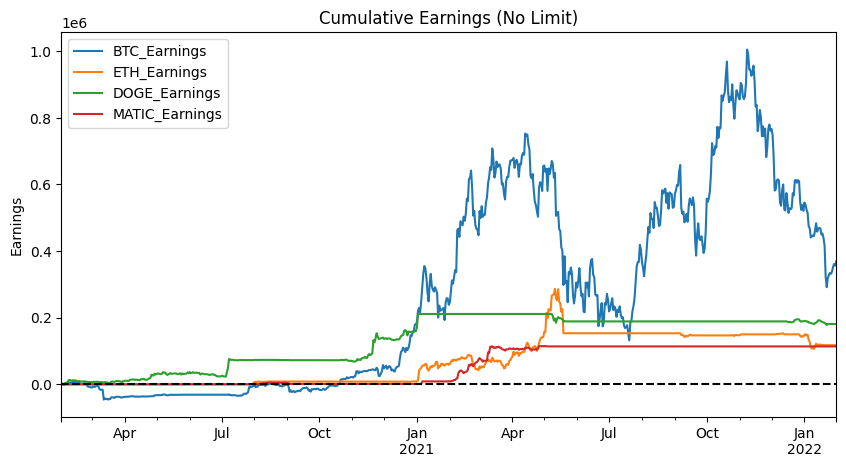

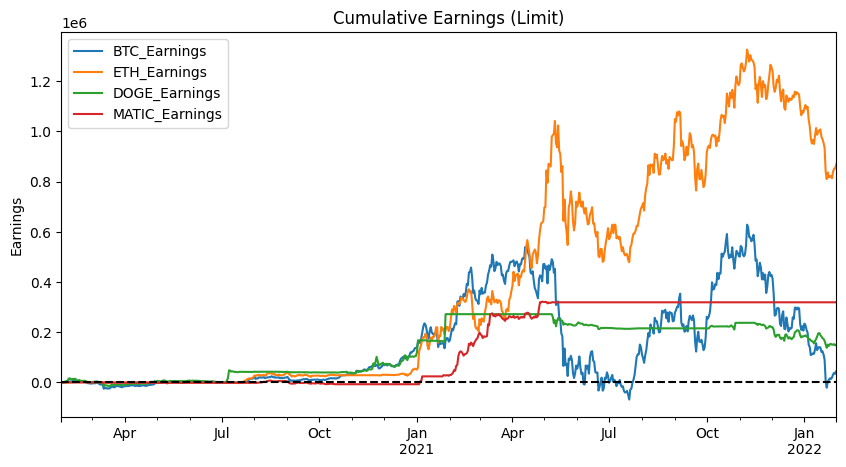

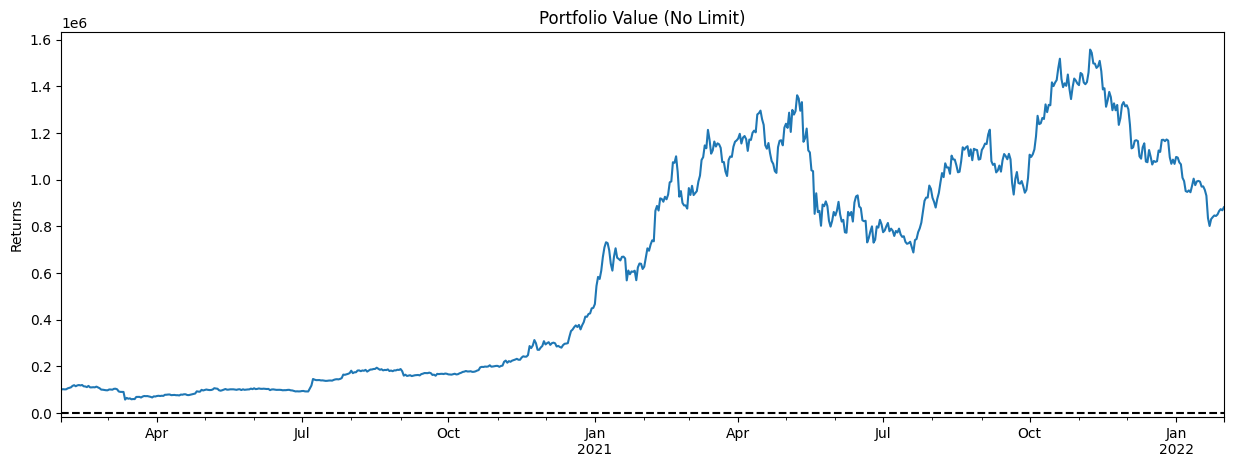

2020-02-01    1.009474e+05
2020-02-02    2.030449e+05
2020-02-03    3.043265e+05
2020-02-04    4.060026e+05
2020-02-05    5.118258e+05
                  ...     
2022-01-27    4.568891e+08
2022-01-28    4.577546e+08
2022-01-29    4.586282e+08
2022-01-30    4.594968e+08
2022-01-31    4.603784e+08
Freq: D, Name: Portfolio_value, Length: 731, dtype: float64


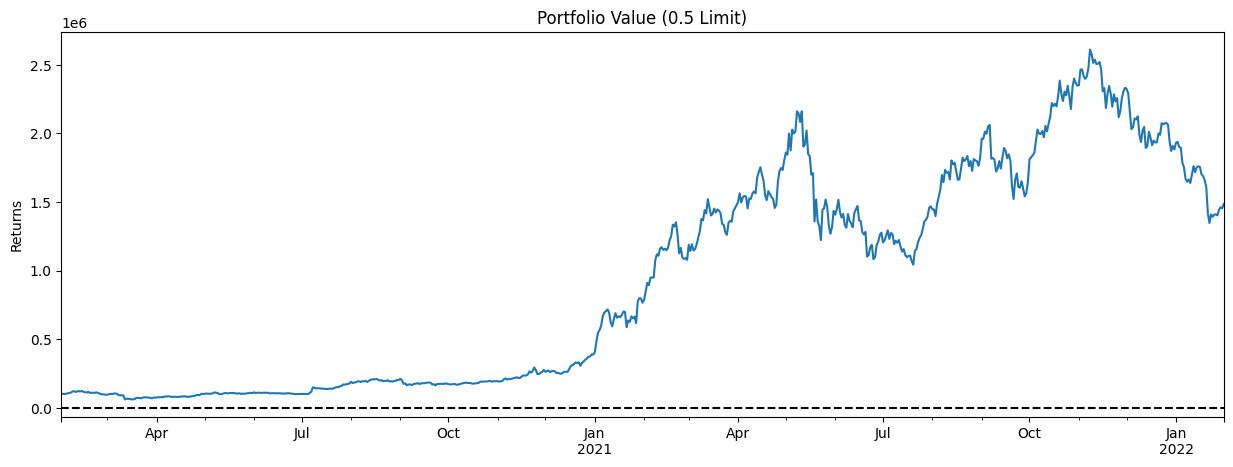

2020-02-01    1.008397e+05
2020-02-02    2.024538e+05
2020-02-03    3.032640e+05
2020-02-04    4.047422e+05
2020-02-05    5.102043e+05
                  ...     
2022-01-27    6.741135e+08
2022-01-28    6.755557e+08
2022-01-29    6.770171e+08
2022-01-30    6.784710e+08
2022-01-31    6.799566e+08
Freq: D, Name: Portfolio_value, Length: 731, dtype: float64


In [19]:
def cum_earnings_plot(df, df_type):
    # convert returns to % and plot the returns series for all stocks
    df[earnings].expanding(0).apply(lambda x: sum(x), raw = True).plot(figsize = (10, 5))
    plt.title(f"Cumulative Earnings ({df_type})")
    plt.ylabel("Earnings")
    plt.axhline(y=0, color='black', linestyle='--')
    plt.show()

cum_earnings_plot(no_limit_df, 'No Limit')
cum_earnings_plot(limit_df, 'Limit')

def portfolio_returns_plot(df, df_type):
    df['Portfolio_value'].plot(figsize = (15, 5))
    plt.title(f"Portfolio Value ({df_type})")
    plt.ylabel("Returns")
    plt.axhline(y=0, color='black', linestyle='--')
    plt.show()
    print(df['Portfolio_value'].expanding(0).apply(lambda row : np.sum(row), raw=True))

portfolio_returns_plot(no_limit_df, 'No Limit')
portfolio_returns_plot(limit_df, '0.5 Limit')

# Calculate the VaR(5%) for the component assets

At 𝛼 = 5% level, estimate daily VaR and ES of the percentage return (not value) of: all the 
individual component crypto assets and the portfolio (no limit to holding weights setting). Plot 
and show the VaR and ES curves for one year (2021-2-1 to 2022-2-1). 

In [20]:
portfolio = no_limit_df.copy().reset_index()
portfolio['Adj Close'] = portfolio['Portfolio_value']
portfolio['Prev Close'] = portfolio['Adj Close'].shift(1)
portfolio['log_return'] = np.log(portfolio['Adj Close']/portfolio['Prev Close'])
portfolio['perc_return'] = (portfolio['Adj Close']/portfolio['Prev Close']) - 1
portfolio = portfolio.rename(columns = {'index' : "Date"})
portfolio = portfolio[portfolio['Date'] < '2022-02-01']
coins["PORT"] = portfolio

### Historical Method

In [21]:
for key in coins.keys():
    # Calculate parametric VaR and ES for past 250 days for each row
    df = coins[key]
    returns = df['perc_return'].values
    for i in range(0, len(df)):
        if i < window_size:
            df.loc[i, 'h_var'] = np.NaN
            df.loc[i, 'h_es'] = np.NaN
        else:
            past_window = returns[(i-window_size):i]
            var = np.quantile(past_window,0.05) 
            df.loc[i, 'h_var'] = var
            df.loc[i, 'h_es'] = past_window[past_window<var].mean()
    # Add new columns to the dataframe
    coins[key] = df


C:\Users\ktkkc\AppData\Local\Temp\ipykernel_38308\3089179368.py:13: RuntimeWarning: Mean of empty slice.
  df.loc[i, 'h_es'] = past_window[past_window<var].mean()
c:\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\ktkkc\AppData\Local\Temp\ipykernel_38308\3089179368.py:13: RuntimeWarning: Mean of empty slice.
  df.loc[i, 'h_es'] = past_window[past_window<var].mean()
c:\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\ktkkc\AppData\Local\Temp\ipykernel_38308\3089179368.py:13: RuntimeWarning: Mean of empty slice.
  df.loc[i, 'h_es'] = past_window[past_window<var].mean()
c:\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\ktkkc\AppData\Local\Temp\ipykernel

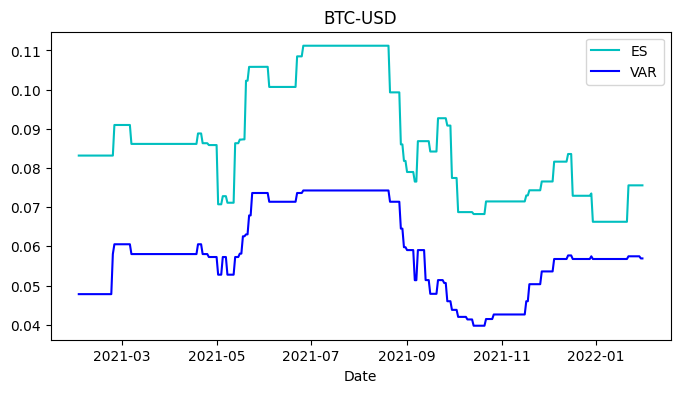

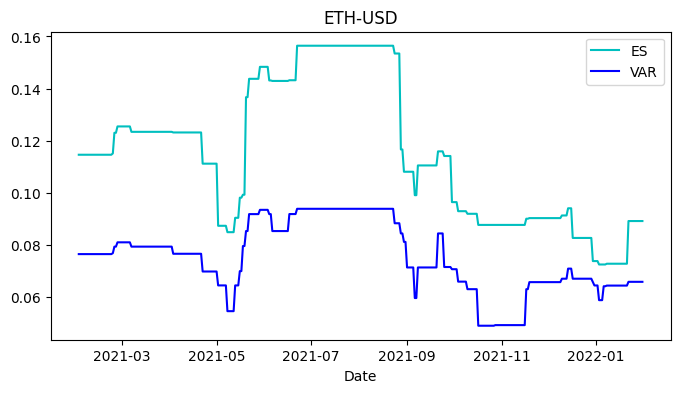

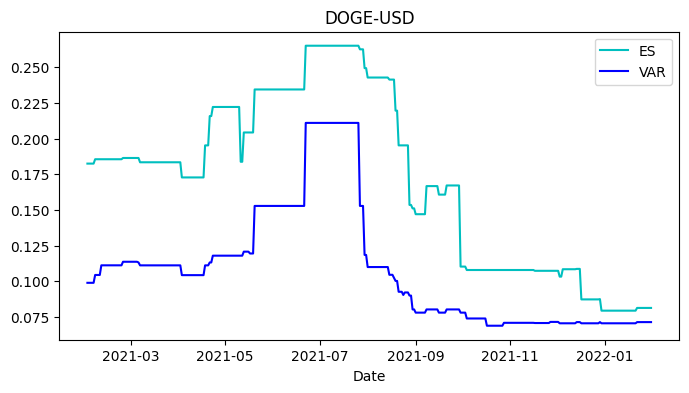

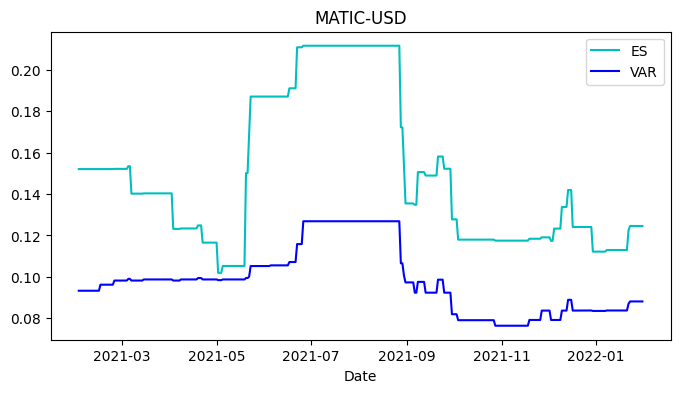

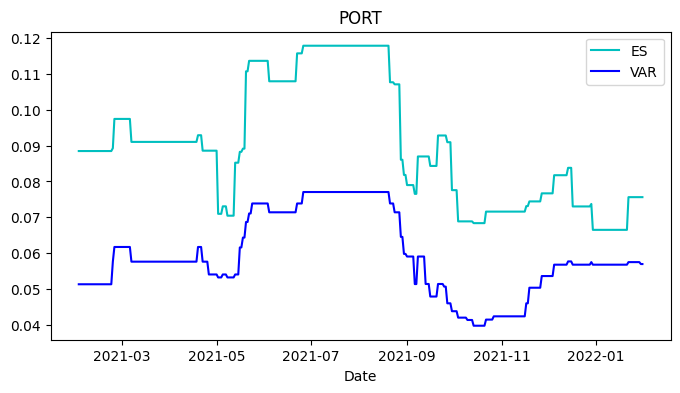

In [22]:
for coin in coins.keys():
    df = coins[coin].copy()
    date_range = pd.date_range(start='2021-02-01', end='2022-02-01')
    df = df.loc[(df['Date'] >= date_range[0]) & (df['Date'] <= date_range[-1])]
    plt.figure(figsize = (8, 4))
    plt.plot(df['Date'], -df['h_es'], 'c', label='ES')
    plt.plot(df['Date'], -df['h_var'], 'b', label='VAR')
    plt.xlabel('Date')
    plt.title(coin)
    plt.legend()
    plt.show()

### Parametric Method

**Helper function to calculate the portfolio variance of a given portfolio**

This function takes in the data for all the stocks in the portfolio for a given set of dates, and their respective weights in the portfolio. Then it creates a Covariance matrix and calculates the portfolio variance from there

In [23]:
#Portfolio Covariance Helper Function
def port_var(data, weights):
    cv = np.cov(data) if len(data[0]) > 1 else np.NaN #Covariance Matrix of log returns
    # cv_p = np.exp(cv) - 1 #Convert ot percentage return to perform weighting
    
    #Calculate Variance of portfolio
    variance_perc = np.dot(weights, np.dot(cv, weights))
    variance = np.log(variance_perc + 1)
    return variance

# Create a dataframe with the perc_returns of each coin
perc_returns = pd.DataFrame()
perc_returns['Date'] = coins['BTC-USD']['Date']
for coin, data in coins.items():
  col_name = str(coin) + "_perc_return"
  perc_returns[col_name] = data['perc_return']

# Join the holding weights and the prec_returns into a single dataframe
final_df = pd.merge(portfolio, perc_returns, on = "Date")
final_df["port_var"] = np.nan
final_df["port_es"] = np.nan
# final_df


def parametric_var_es(returns, confidence_level):
    mean_return = np.mean(returns)
    std_dev = np.std(returns)
    var = norm.ppf(1 - confidence_level, mean_return, std_dev)
    es = mean_return - (std_dev * norm.pdf(norm.ppf(1 - confidence_level)) / (1 - confidence_level))
    return -var, es



In [24]:
# CALCULATE PARAMETRIC VAR AND ES FOR EACH INDIVIDUAL COIN
# Loop over each dataframe in the dictionary
for key in coins.keys():
    # Calculate parametric VaR and ES for past 50 days for each row
    # Note that this is for the individual coins and not for portfolio
    df = coins[key]
    returns = df['perc_return'].values
    z_alpha = norm.ppf(0.05, loc = 0, scale = 1)
    for i in range(0, len(df)):
        if i < window_size:
            df.loc[i, 'p_var'] = np.NaN
            df.loc[i, 'p_es'] = np.NaN              
        else:
            past_window = returns[(i-window_size):i]
            # std_50 = past_window.std()
            # mean_50 = past_window.mean()

            p_var, p_es = parametric_var_es(past_window, 0.95)
            df.loc[i, 'p_var'] = p_var
            df.loc[i, 'p_es'] = p_es
            # df.loc[i, 'p_var'] = mean_50 - std_50 * z_alpha
            # df.loc[i, 'p_es'] = -mean_50 - std_50 / 0.05 * np.exp(-0.5 * ((z_alpha**2) - 1)) / np.sqrt(2 * np.pi)

    # Add new columns to the dataframe
    coins[key] = df


In [25]:
# CALCULATE PARAMETRIC VAR AND ES FOR PORTFOLIO
pf = ["BTC-USD","ETH-USD","DOGE-USD","MATIC-USD"]
z_alpha = norm.ppf(0.05, loc = 0, scale = 1)

# Iterate through the final_df from the 50th day onwards, rolling window size
for i in range(window_size, len(final_df)):
  # Portfolio Weight for each given row
  pfw = []
  for coin in pf:
    pfw.append(final_df.loc[i, coin])
  
  # List of 50 day returns for all coins
  btc_values = list(final_df['BTC-USD_perc_return'])
  eth_values = list(final_df['ETH-USD_perc_return'])
  doge_values = list(final_df['DOGE-USD_perc_return'])
  matic_values = list(final_df['MATIC-USD_perc_return'])
  port_values = list(final_df['PORT_perc_return'])

  btc_past_window = btc_values[(i - window_size): i]
  eth_past_window = eth_values[(i - window_size): i]
  doge_past_window = doge_values[(i - window_size): i]
  matic_past_window = matic_values[(i - window_size): i]
  port_past_window = port_values[(i - window_size): i]

  data = np.array([btc_past_window, eth_past_window, doge_past_window, matic_past_window])
  var = port_var(data, pfw)
  sigma = sqrt(var)
  mu = np.mean(port_past_window)

  # values_at_risk, expected_shortfall = parametric_var_es()

  var = norm.ppf(0.05, mu, sigma)
  es = mu - (sigma * norm.pdf(norm.ppf(0.05)) / (0.05))

  final_df.loc[i, 'port_var'] = -var
  final_df.loc[i, 'port_es'] = es
  # final_df.loc[i, 'port_var'] = mu - sigma * z_alpha
  # final_df.loc[i, 'port_es'] = -mu - sigma / 0.05 * np.exp(-0.5 * ((z_alpha**2) - 1)) / np.sqrt(2 * np.pi)


# final_df

In [26]:
plot = pd.DataFrame()
plot['Date'] = coins['BTC-USD']['Date']

plot["btc_var"] = coins['BTC-USD']['p_var'] 
plot["eth_var"] = coins['ETH-USD']['p_var'] 
plot["doge_var"] = coins['DOGE-USD']['p_var'] 
plot["matic_var"] = coins['MATIC-USD']['p_var']
plot['port_var'] = final_df['port_var']

plot["btc_es"] = coins['BTC-USD']['p_es'] 
plot["eth_es"] = coins['ETH-USD']['p_es'] 
plot["doge_es"] = coins['DOGE-USD']['p_es'] 
plot["matic_es"] = coins['MATIC-USD']['p_es']
plot['port_es'] = final_df['port_es']

#Filter out for plotting period 
start_date = '2021-02-01'
end_date = '2022-02-01'

mask = (plot['Date'] >= start_date) & (plot['Date'] <= end_date)
plot2 = plot[mask]

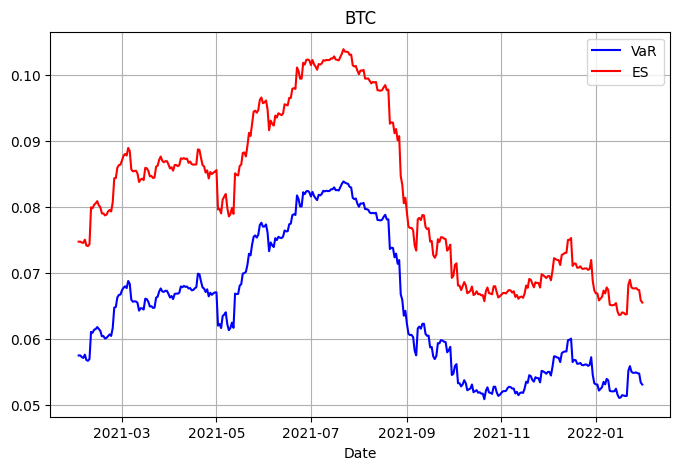

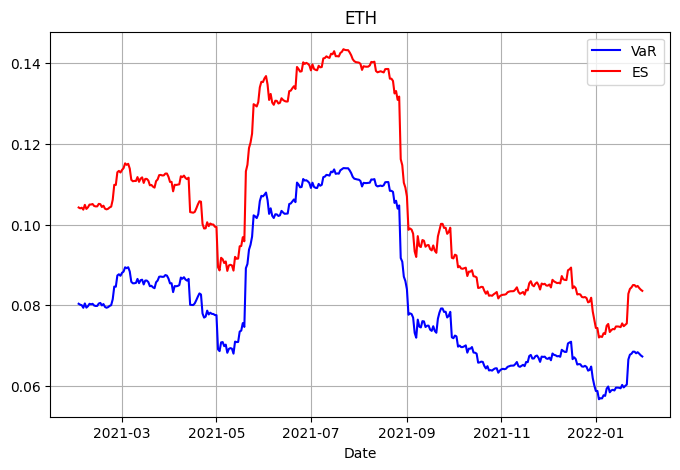

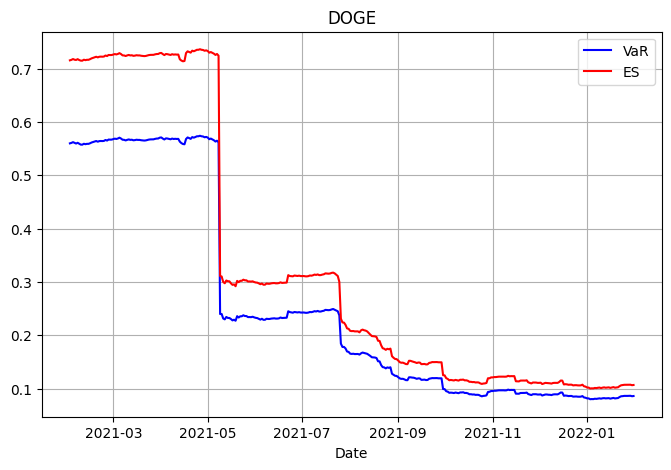

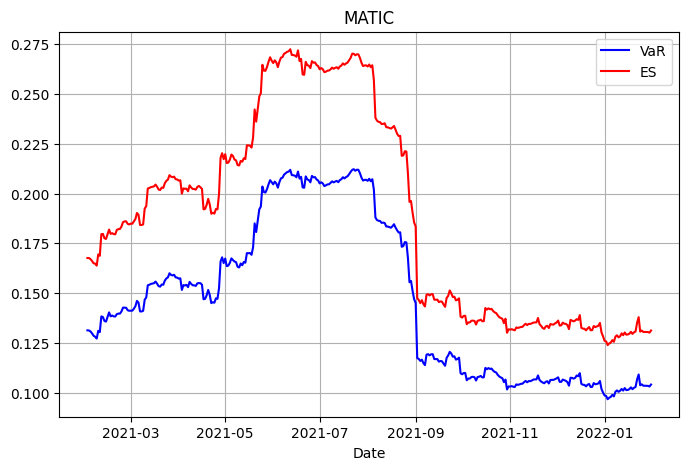

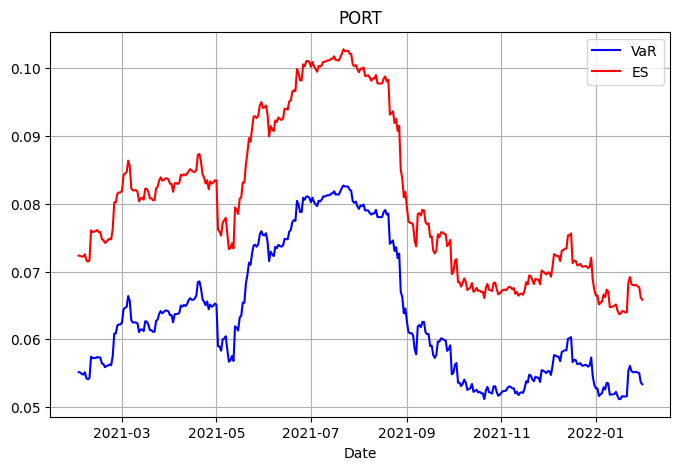

In [27]:
names = ['btc', 'eth', 'doge', 'matic', 'port']
for name in names:
  plt.figure(figsize = (8, 5))
  var = name + '_var'
  es = name + '_es'
  plt.plot(plot2['Date'], plot2[var], 'b-', label = "VaR")
  plt.plot(plot2['Date'], -plot2[es], 'r-', label = 'ES')
  plt.xlabel('Date')
  plt.legend()
  plt.title(name.upper())
  plt.grid()
  plt.show()

## Q3(b)
Identify the most risky component asset from the above evidence and justify your choice. (<100 
words)

**Answer**  
The most risky componenet asset has the most extreme VaR and ES from the plots, which is DOGE-USD, which has an ES of lowest nearing ~0.80, meaning that you could lose a max of an average of 80% of a share in a day. 

VaR analysis.

# Question 4a

In [28]:
# Calculate the standard deviation of daily log returns
btc_std = combine_df['BTC-USD'].std()
eth_std = combine_df['ETH-USD'].std()

print("BTC-USD Standard Deviation: {:.4f}".format(btc_std))
print("ETH-USD Standard Deviation: {:.4f}".format(eth_std))

BTC-USD Standard Deviation: 0.0399
ETH-USD Standard Deviation: 0.0525


In [29]:
# Calculate the frequency of daily log returns above a certain threshold
threshold = 2 * btc_std
btc_high_freq = (log_returns['BTC-USD'] > threshold).sum() / len(log_returns)
eth_high_freq = (log_returns['ETH-USD'] > threshold).sum() / len(log_returns)

print("BTC-USD High Return Frequency: {:.4f}".format(btc_high_freq))
print("ETH-USD High Return Frequency: {:.4f}".format(eth_high_freq))

BTC-USD High Return Frequency: 0.0274
ETH-USD High Return Frequency: 0.0575


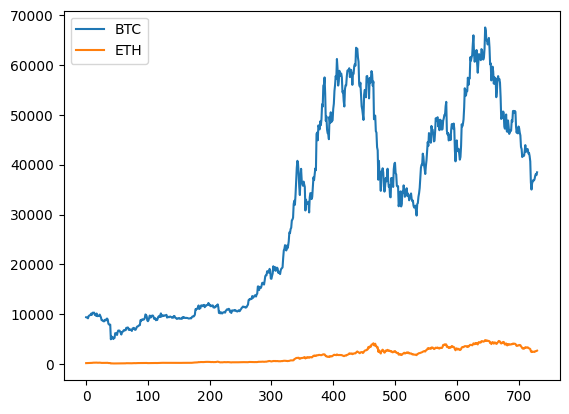

In [30]:
plt.plot(btc["Adj Close"], label='BTC')
plt.plot(eth["Adj Close"], label='ETH')
plt.legend()
plt.show()

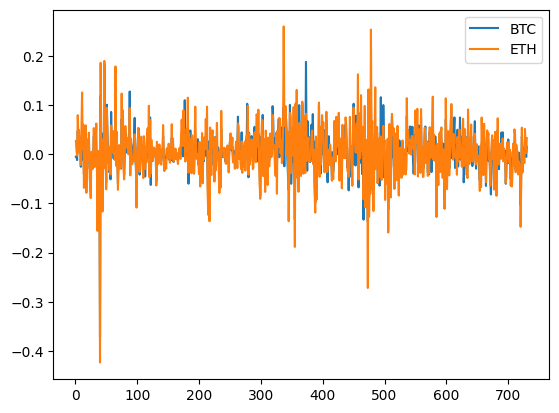

In [31]:
plt.plot(btc["perc_return"], label='BTC')
plt.plot(eth["perc_return"], label='ETH')
plt.legend()
plt.show()

We can see that ETH-USD has a slightly higher frequency of extreme positive daily log returns than BTC-USD. However, this analysis is just a rough comparison and there are other metrics or fundamental analysis that can affect the volatility of a stock.

In [32]:
options_df = pd.read_csv('OKEx_options_trade.csv')
options_df.head()

,Unnamed: 0,side,trade_id,price,qty,instrument_id,timestamp
0,0,side,trade_id,price,qty,instrument_id,timestamp
1,1,buy,100,0.0315,10,BTC-USD-200327-8000-P,2020-01-31T10:19:38.359Z
2,2,buy,54,0.026,1,BTC-USD-200207-9500-C,2020-01-31T22:52:29.429Z
3,3,buy,213,0.052,50,BTC-USD-200327-11000-C,2020-01-31T22:13:11.537Z
4,4,sell,38,0.003,40,BTC-USD-200207-8250-P,2020-01-31T13:40:34.053Z


In [33]:
## Data Cleaning ##
options_df = options_df.drop(index=0)
options_df[options_df['timestamp'] == 'timestamp']
options_df = options_df[options_df['timestamp'] != 'timestamp']

split_string = options_df['instrument_id'].str.split('-', expand=True)
options_df['option_ticker'] = split_string[0] + "-" + split_string[1]
options_df['expiry_date'] = split_string[2]
options_df['strike_price'] = split_string[3].astype(float)
options_df['option_type'] = split_string[4]
options_df.drop(['Unnamed: 0'], axis=1, inplace=True)

options_df.dropna(inplace=True)

options_df['timestamp'] = pd.to_datetime(options_df['timestamp'])

options_df['expiry_date_dt'] = pd.to_datetime(options_df['expiry_date'],format="%y%m%d")
options_df['days_to_maturity'] = (options_df['expiry_date_dt'].dt.date - options_df['timestamp'].dt.date).dt.days

eth_options = options_df[options_df['option_ticker'] == 'ETH-USD']

date_object = pd.to_datetime('2021-01-01')

filtered_options = eth_options[eth_options['expiry_date'] == "210108"]
filtered_options = filtered_options[filtered_options['timestamp'].dt.date == date_object]
filtered_options = filtered_options[filtered_options['side'] == "buy"]


eth_call_options = filtered_options[filtered_options['option_type'] == 'C']
eth_put_options = filtered_options[filtered_options['option_type'] == 'P']
eth_call_options['strike_price'].sort_values()

c:\Python310\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


78348     700.0
78345     700.0
76083     700.0
76641     700.0
75775     700.0
75774     700.0
75773     700.0
75670     700.0
75608     700.0
77159     700.0
76361     700.0
75128     700.0
77471     700.0
75137     700.0
75099     700.0
73963     700.0
78284     700.0
74028     700.0
77759     700.0
74394     700.0
74594     700.0
76360     700.0
77627     740.0
74296     740.0
75568     740.0
75060     740.0
73910     740.0
76563     740.0
76210     740.0
76642     760.0
77472     760.0
76888     760.0
76084     760.0
73993     760.0
75609     760.0
74395     760.0
75100     760.0
76890     780.0
77016     780.0
76564     800.0
75789     800.0
78137     800.0
76892     800.0
76211     800.0
77628     800.0
77114     960.0
77474     960.0
76178    1000.0
77689    1000.0
75149    1000.0
75105    1000.0
76675    1000.0
75614    1000.0
74400    1000.0
73866    1000.0
Name: strike_price, dtype: float64

### Case 1: Finding the instrument-ids by following question requirements 

In [34]:
eth_price = prices_df[prices_df.index == '2021-01-01']['ETH-USD'].values[0]
print(f'ETH Market Price: {eth_price}')
quantiles = combine_df['ETH-USD'].quantile([0.16,0.84]) # log_returns quantiles
print(f'Quantiles: {quantiles}')

ETH Market Price: 730.3675537109375
Quantiles: 0.16   -0.035463
0.84    0.045466
Name: ETH-USD, dtype: float64


Explanation for why we use `.std()`  
This is because when we do the quantile method like what Noah did, the quantile return value was so small that it doesnt change the so called upper and lower bound of our market price. Compared to the code below which shows that `put_target_price` and the `call_target_price` are significantly different from its market price  
Other Options we can consider:  
1. `no_limit_df['ETH_Earnings'].std()` assumes normal distribution
2. `no_limit_df['ETH_Earnings'].quantile([0.16,0.84])` doesnt assume normal
3. `combine_df[ETH-USD].quantiles([0.16,0.84])`
4. `combine_df['ETH-USD'].std()`

In [35]:
put_target_price = np.exp(quantiles[0.16]) * eth_price
call_target_price = np.exp(quantiles[0.84]) * eth_price
print(put_target_price, call_target_price) 

704.9202781141021 764.3411428695032


In [36]:
# Finding the put and call option closest to the 
put_diff = (eth_put_options['strike_price'] - put_target_price).abs()
put_closest_index = put_diff.idxmin()
put_closest_data = eth_put_options.loc[put_closest_index, 'instrument_id']
print(f'The closest price point to {put_target_price} is {put_closest_data}')

call_diff = (eth_call_options['strike_price'] - call_target_price).abs()
call_closest_index = call_diff.idxmin()
call_closest_data = eth_call_options.loc[call_closest_index, 'instrument_id']
print(f'The closest price point to {call_target_price} is {call_closest_data}')


call_option_buy = eth_call_options.loc[(eth_call_options['strike_price']- call_target_price).abs().idxmin()]
put_option_buy = eth_put_options.loc[(eth_put_options['strike_price']- put_target_price).abs().idxmin()]

The closest price point to 704.9202781141021 is ETH-USD-210108-680-P
The closest price point to 764.3411428695032 is ETH-USD-210108-760-C


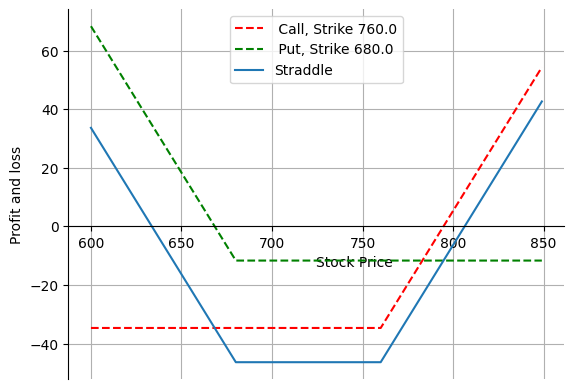

In [37]:
sT = np.arange(600,850,1)

def call_profit_earnings(sT, strike_price, premium):
    return np.where(sT > strike_price, sT - strike_price, 0) - (premium * eth_price)

def put_profit_earnings(sT, strike_price, premium):
    return np.where(sT < strike_price,strike_price - sT, 0) - (premium * eth_price)

profit_loss_call = call_profit_earnings(sT, call_option_buy['strike_price'],float(call_option_buy['price']))
profit_loss_put = put_profit_earnings(sT, put_option_buy['strike_price'],float(put_option_buy['price']))

profit_loss_straddle = profit_loss_call + profit_loss_put

fig, ax = plt.subplots()
ax.spines['top'].set_visible(False) # Top border removed
ax.spines['right'].set_visible(False) # Right border removed
ax.spines['bottom'].set_position('zero') # Sets the X-axis in the center

ax.plot(sT,profit_loss_call,'--',label=' Call, Strike {}'.format(call_option_buy['strike_price']),color='r')
ax.plot(sT,profit_loss_put,'--',label=' Put, Strike {}'.format(put_option_buy['strike_price']),color='g')

ax.plot(sT,profit_loss_straddle,label='Straddle')
plt.xlabel('Stock Price', ha='left')
plt.ylabel('Profit and loss')
plt.grid()
plt.legend()
plt.show()

### Without Straddle

**How to interpret Sharpe Ratio**  
Sharpe ratio measures the risk-adjusted return of an investment or portfolio Sharpe Ratio 
= (Expected Return of Investment - Risk-Free Rate) / Standard Deviation of Investment's Returns.  
The higher the Sharpe ratio, the better the risk-adjusted return of the investment. A higher Sharpe
ratio indicates that an investment is generating more return per unit of risk compared to a 
lower Sharpe ratio investment.

In [38]:
# calculate Sharpe Ratio, and annualize it by multiplying sqrt(365) 
# as crypto is traded on every day of the year

annualized_sharpe_ratio = no_limit_df['weighted_sr'].mean() / no_limit_df['weighted_sr'].std() * 365 ** 0.5
print(f'Annualized Sharpe Ratio (Simple): {annualized_sharpe_ratio}')

print(f'No Limit Annualized Return: {annualized_return_no_limit}')

Annualized Sharpe Ratio (Simple): 1.7762886323386324
No Limit Annualized Return: 1.9551137682586077


## With Straddle

In [39]:
select_put_option_id = 'ETH-USD-210108-680-P'
select_call_option_id = 'ETH-USD-210108-760-C'

call_id=eth_call_options[eth_call_options['instrument_id'] == select_call_option_id]
call_cost = float(call_id['price'].sort_values().values[0]) # to find minimum price of call_ids if there are more than one
print(f'Call Premium Price: {call_cost}ETH')

Call Premium Price: 0.0415ETH


In [40]:
put_id=eth_put_options[eth_put_options['instrument_id'] == select_put_option_id]
put_cost = float(put_id['price'].sort_values().values[0]) # to find minimum price of call_ids if there are more than one
print(f'Put Premium Price: {put_cost}ETH')

Put Premium Price: 0.016ETH


In [41]:
eth_price

730.3675537109375

In [42]:
# To account for straddle, find current price of eth on 2021-01-08, calculate payoff on the day 
# and add back to the returns

currprice = prices_df[prices_df.index == '2021-01-08']['ETH-USD'].values[0]
print("ETH Current Price: ", currprice)
marketprice = eth_price
print("ETH Market Price: ", marketprice)

put_option_ex_price = 680
call_option_ex_price = 760

def payoff_cost(curr, put, call, put_cost, call_cost, marketprice):
    # cost = 1 * (put_cost + call_cost) * marketprice
    # payoff = -1 * (put_cost + call_cost) * marketprice
    payoff = 0
    if curr <= put_option_ex_price:
        # exercise put option
        payoff += (put_option_ex_price -  curr)
    elif curr >= call_option_ex_price:
        # exercist call option
        payoff += (curr - call_option_ex_price)
    return payoff

payoff= payoff_cost(currprice, put_option_ex_price, call_option_ex_price, put_cost, call_cost, marketprice)
print(f'Payoff: {payoff}')

ETH Current Price:  1224.1971435546875
ETH Market Price:  730.3675537109375
Payoff: 464.1971435546875


In [43]:
straddle_df

amt_invested = 100000
earnings = ['BTC_Earnings', 'ETH_Earnings', 'DOGE_Earnings', 'MATIC_Earnings']

def cumulative_earnings_straddle(holdingweight_df, simplereturn_df, column_names, amt_invested, payoff):
    curr_amt= amt_invested # current amount invested in the portfolio
    # Loop through each day in the data
    for i in range(len(holdingweight_df)):
        weights = holdingweight_df.loc[holdingweight_df.index[i], assets].values # locating the weights for the current day
        returns = simplereturn_df.iloc[i].values # locating the simple returns for the current day
        holdingweight_df.loc[holdingweight_df.index[i], column_names] = weights * returns * curr_amt # assigning the calculated earnings to the respective column in the earnings variable
        weighted_sr = weights * returns
        holdingweight_df.loc[holdingweight_df.index[i], 'weighted_sr'] = weighted_sr.sum()

        # Recalculating the current amount invested in the portfolio with sum of the earnings plus previous loop amout invested
        curr_amt = holdingweight_df.loc[holdingweight_df.index[i], column_names].values.sum() + curr_amt

        if holdingweight_df.index[i] == pd.to_datetime('2021-01-08'):
            curr_amt += payoff
    return holdingweight_df

straddle_df = cumulative_earnings_straddle(straddle_df, simple_returns, earnings, amt_invested, payoff)

straddle_df['weighted_logreturn'] = np.log(straddle_df['weighted_sr'] + 1)

straddle_df['Portfolio'] = straddle_df[earnings].sum(axis=1)

straddle_df['Portfolio_value'] = amt_invested + straddle_df['Portfolio'].expanding(0).apply(lambda row : np.sum(row), raw=True)
straddle_df['Portfolio_value_perc_change'] = (straddle_df['Portfolio_value']/straddle_df['Portfolio_value'].shift(1)) -1

annualized_return_straddle = (straddle_df['Portfolio_value'][-1] / straddle_df['Portfolio_value'][0]) ** (1/2) - 1

print(f'Annnualized returns with one-off straddle: {annualized_return_straddle}')

annualized_sharpe_ratio_straddle = straddle_df['Portfolio_value_perc_change'].mean() / straddle_df['Portfolio_value_perc_change'].std() * 365 ** 0.5
print(f'Annualized Sharpe Ratio with One-Off Straddle: {annualized_sharpe_ratio_straddle}')

Annnualized returns with one-off straddle: 1.955273045528481
Annualized Sharpe Ratio with One-Off Straddle: 1.7713756904283926


In [53]:
straddle_df.head()

,BTC-USD,ETH-USD,DOGE-USD,MATIC-USD,BTC_Earnings,ETH_Earnings,DOGE_Earnings,MATIC_Earnings,weighted_sr,weighted_logreturn,Portfolio,Portfolio_value,Portfolio_value_perc_change
2020-02-01,0.330609,0.0,0.655712,0.013679,149.722743,4.407847e-16,766.913675,3.074959e+01,0.009474,0.009429,947.386004,100947.386004,NaN
2020-02-02,0.328128,0.0,0.658097,0.013775,-171.068242,6.227514e-16,1261.733401,5.947106e+01,0.011393,0.011329,1150.136216,102097.522219,0.011393
2020-02-03,0.522288,-0.0,0.476095,0.001617,-290.143656,-4.370254e-17,-551.469411,2.565834e+01,-0.007992,-0.008024,-815.954729,101281.567490,-0.007992
2020-02-04,0.578006,-0.0,0.421994,-0.0,-709.024540,1.113853e-16,1103.538037,3.101475e-15,0.003895,0.003888,394.513497,101676.080987,0.003895
2020-02-05,0.593596,-0.0,0.406404,-0.0,2842.942634,-3.122334e-15,1304.200120,-1.226997e-15,0.040788,0.039978,4147.142754,105823.223741,0.040788


In [44]:
print(f'Annnualized returns with one-off straddle: {annualized_return_straddle}')
print(f'Annnualized returns: {annualized_return_no_limit}')
print(f'Difference in returns: {annualized_return_straddle - annualized_return_no_limit}')

Annnualized returns with one-off straddle: 1.955273045528481
Annnualized returns: 1.9551137682586077
Difference in returns: 0.0001592772698733036


In [45]:
annualized_sharpe_ratio = no_limit_df['weighted_sr'].mean() / no_limit_df['weighted_sr'].std() * 365 ** 0.5
print(f'Annualized Sharpe Ratio (Simple): {annualized_sharpe_ratio}')

annualized_sharpe_ratio_straddle = straddle_df['Portfolio_value_perc_change'].mean() / straddle_df['Portfolio_value_perc_change'].std() * 365 ** 0.5
print(f'Annualized Sharpe Ratio with One-Off Straddle: {annualized_sharpe_ratio_straddle}')

# print(f'Difference in Sharpe Ratio: {annualized_sharpe_ratio_straddle - annualized_sharpe_ratio}')

Annualized Sharpe Ratio (Simple): 1.7762886323386324
Annualized Sharpe Ratio with One-Off Straddle: 1.7713756904283926


# Designing hedging strategies

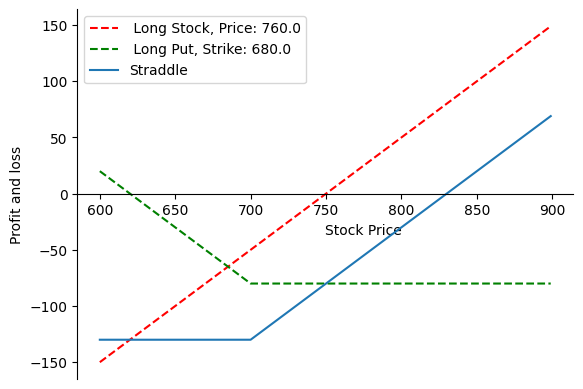

In [46]:
sT = np.arange(600,900,1)

def long_earnings(sT, price_bought):
    return sT - price_bought

def put_profit_earnings(sT, strike_price, premium):
    return np.where(sT < strike_price,strike_price - sT, 0) - premium

puchased_price = 750
profit_loss_long = long_earnings(sT,puchased_price)
profit_loss_put = put_profit_earnings(sT, 700, 80)

profit_loss_straddle = profit_loss_long + profit_loss_put

fig, ax = plt.subplots()
ax.spines['top'].set_visible(False) # Top border removed
ax.spines['right'].set_visible(False) # Right border removed
ax.spines['bottom'].set_position('zero') # Sets the X-axis in the center

ax.plot(sT,profit_loss_long,'--',label=' Long Stock, Price: {}'.format(call_option_buy['strike_price']),color='r')
ax.plot(sT,profit_loss_put,'--',label=' Long Put, Strike: {}'.format(put_option_buy['strike_price']),color='g')

ax.plot(sT,profit_loss_straddle,label='Straddle')
plt.xlabel('Stock Price', ha='left')
plt.ylabel('Profit and loss')
plt.legend()
plt.show()

In [47]:
#the filter to finding the options
def find_options(option_prices, date, price_mean, price_sd, percentile, leq, option_type, option_ticker, side):
    # strike_price = option_prices['strike_price']
    # interval_val = price_mean + ((price_sd * (option_prices['days_to_maturity'] ** 0.5)) * norm.ppf(percentile))
    # print(f'Strike Price: {strike_price}')
    # print(f'Interval Value: {interval_val}')
    
    result = option_prices[(option_prices['timestamp'].dt.date == date.date()) # if the option is bought/sold on the same date as
                   & (option_prices["option_type"] == option_type) # if the option_type same as our current option type
                   & (option_prices['option_ticker'] == option_ticker) # if the ticker same as 
                   & (option_prices['side'] == side) # side of option

                   # to determine price range for options we are looking for (e.g. we want put options that are around the price of our risk tolerance so that we can hedge against further losses)
                   & (option_prices['strike_price'] <= price_mean + ((price_sd * (option_prices['days_to_maturity'] ** 0.5)) * norm.ppf(percentile)) 
                      if leq else
                      option_prices['strike_price'] >= price_mean + ((price_sd * (option_prices['days_to_maturity'] ** 0.5)) * norm.ppf(percentile)))][['price', 'strike_price', 'expiry_date_dt']]
                    #took into account the number of days to maturity
    if not result.empty:
        return result
    else:
        return

In [48]:
#the iteration to finding the options
def get_options_buys(prices_df, options_prices, sd_days, percentile, leq, option_type, side):
    options_tickers = ['BTC-USD', 'ETH-USD']

    simulated_options_trade = prices_df.copy()

    simulated_options_trade['BTC_options_strike'] = [np.nan] * (len(simulated_options_trade))
    simulated_options_trade['BTC_options_exp_date'] = [np.nan] * (len(simulated_options_trade))
    simulated_options_trade['BTC_options_price'] = [np.nan] * (len(simulated_options_trade))
    simulated_options_trade['ETH_options_strike'] = [np.nan] * (len(simulated_options_trade))
    simulated_options_trade['ETH_options_exp_date'] = [np.nan] * (len(simulated_options_trade))
    simulated_options_trade['ETH_options_price'] = [np.nan] * (len(simulated_options_trade))
    # print(simulated_options_trade)

    eth_option_exp = []
    btc_option_exp = []
    for i in range(sd_days,len(prices_df)):


        #get the past standard dev
        for ticker in options_tickers: # for the BTC first, then the ETH
            sd = prices_df[i: i + sd_days].std()[ticker] # finding the std for the past window size
            avg = prices_df[i: i + sd_days].mean()[ticker] # finding the mean for the past window size 

            # 2nd parameter is the date
            # sd_days, percentile, leq, option_type all hardcoded
            option_to_buy = find_options(options_prices, prices_df[i:i+1].index[0], avg, sd, percentile, leq, option_type, ticker, side)

            if option_to_buy is not None:

                ticker_str = ticker[0:3]
                #get max strike price -> to find price closest to our risk level
                #might need to change per different strats
                temp_option = option_to_buy.sort_values('strike_price',ascending=False).iloc[0]
                # NEW: adding in check for whether we have an option covering this date's value
                if ticker_str == 'BTC':
                    if temp_option['expiry_date_dt'] in btc_option_exp:
                        # we already have an option which exercises on this date so we do not want to buy this
                        continue
                    else:
                        simulated_options_trade.loc[prices_df.index[i], '{}_options_strike'.format(ticker_str)] = temp_option['strike_price']
                        simulated_options_trade.loc[prices_df.index[i], '{}_options_exp_date'.format(ticker_str)] = temp_option['expiry_date_dt']
                        simulated_options_trade.loc[prices_df.index[i], '{}_options_price'.format(ticker_str)] = temp_option['price']
                        btc_option_exp.append(temp_option['expiry_date_dt'])

                else: # if ETH Option
                    if temp_option['expiry_date_dt'] in eth_option_exp:
                        # we already have an option which exercises on this date so we do not want to buy this
                        continue
                    else:
                        simulated_options_trade.loc[prices_df.index[i], '{}_options_strike'.format(ticker_str)] = temp_option['strike_price']
                        simulated_options_trade.loc[prices_df.index[i], '{}_options_exp_date'.format(ticker_str)] = temp_option['expiry_date_dt']
                        simulated_options_trade.loc[prices_df.index[i], '{}_options_price'.format(ticker_str)] = temp_option['price']
                        eth_option_exp.append(temp_option['expiry_date_dt'])
                

    return simulated_options_trade

In [49]:
sd_days = 100 # Window Size
percentile = 0.16 # Risk level
leq = True #dependent on type of option True for Put, False for Call
option_type = 'P'
side = 'buy'

options_bought = get_options_buys(prices_df, options_df, sd_days,percentile, leq, option_type, side)
options_bought = options_bought.dropna(subset=['BTC_options_strike','ETH_options_strike'], how='all')

In [50]:
def option_cost_payoff_check(options_bought, timestamp): #function to determine if any option is bought or exercised on a given day
    payoff = 0

    if timestamp in options_bought['BTC_options_exp_date'].values:
        #no need to iterate as we should only have one option exericisng on the day

        #if BTC option has exercise date today then check whether we exercise
        btc_strike = options_bought.loc[options_bought['BTC_options_exp_date'] == timestamp]['BTC_options_strike'].values[0]
        btc_price = options_bought.loc[options_bought['BTC_options_exp_date'] == timestamp]['BTC-USD'].values[0]
        if btc_strike >= btc_price: 
            payoff += btc_strike - btc_price

    if timestamp in options_bought['ETH_options_exp_date'].values:
        
        #if ETH option has exercise date today then check whether we exercise
        eth_strike = options_bought.loc[options_bought['ETH_options_exp_date'] == timestamp]['ETH_options_strike'].values[0]
        eth_price = options_bought.loc[options_bought['ETH_options_exp_date'] == timestamp]['ETH-USD'].values[0]
        if eth_strike >= eth_price: #we choose to exercise option
            payoff += eth_strike - eth_price

        
    if timestamp in options_bought.index:        # option is bought on this date
        multi = options_bought.loc[options_bought.index == timestamp] # if there are more than one option bought

        for i in range(len(multi)):
            curr_option = multi.iloc[i]
            #check whether btc or eth and find price
            if np.isnan(float(curr_option['ETH_options_price'])):
                #BTC Option
                option_price = float(curr_option['BTC_options_price'])
                option_cost = option_price * curr_option['BTC-USD']
                payoff -= option_cost
            else:
                #ETH Option
                option_price = float(curr_option['ETH_options_price'])
                option_cost = option_price * curr_option['ETH-USD']
                payoff -= option_cost
    return payoff # returns payoff if option exercised/bought or 0

In [51]:
marput_df = no_limit_df.copy()

In [52]:
# Write function to run through dates in no_limit_df and execute options along the way

amt_invested = 100000
earnings = ['BTC_Earnings', 'ETH_Earnings', 'DOGE_Earnings', 'MATIC_Earnings']

def cumulative_earnings_marput(holdingweight_df, simplereturn_df, column_names, amt_invested, options_bought):
    curr_amt= amt_invested # current amount invested in the portfolio
    # Loop through each day in the data
    for i in range(len(holdingweight_df)):
        weights = holdingweight_df.loc[holdingweight_df.index[i], assets].values # locating the weights for the current day
        returns = simplereturn_df.iloc[i].values # locating the simple returns for the current day
        holdingweight_df.loc[holdingweight_df.index[i], column_names] = weights * returns * curr_amt # assigning the calculated earnings to the respective column in the earnings variable
        weighted_sr = weights * returns
        holdingweight_df.loc[holdingweight_df.index[i], 'weighted_sr'] = weighted_sr.sum()

        # Recalculating the current amount invested in the portfolio with sum of the earnings plus previous loop amout invested
        curr_amt = holdingweight_df.loc[holdingweight_df.index[i], column_names].values.sum() + curr_amt

        # check if option is bought or exercised on current date

        payoff = option_cost_payoff_check(options_bought, holdingweight_df.index[i])
        curr_amt += payoff
    return holdingweight_df

marput_df = cumulative_earnings_marput(marput_df, simple_returns, earnings, amt_invested, options_bought)

marput_df['weighted_logreturn'] = np.log(marput_df['weighted_sr'] + 1)

marput_df['Portfolio'] = marput_df[earnings].sum(axis=1)

marput_df['Portfolio_value'] = amt_invested + marput_df['Portfolio'].expanding(0).apply(lambda row : np.sum(row), raw=True)
marput_df['Portfolio_value_perc_change'] = (marput_df['Portfolio_value']/marput_df['Portfolio_value'].shift(1)) -1

annualized_return_marput = (marput_df['Portfolio_value'][-1] / marput_df['Portfolio_value'][0]) ** (1/2) - 1

print(f'Annnualized returns with Married Put Strategy: {annualized_return_marput}')

annualized_sharpe_ratio_marput = marput_df['Portfolio_value_perc_change'].mean() / marput_df['Portfolio_value_perc_change'].std() * 365 ** 0.5
print(f'Annualized Sharpe Ratio with Married Put Strategy: {annualized_sharpe_ratio_marput}')

Annnualized returns with Married Put Strategy: 1.9642495794685813
Annualized Sharpe Ratio with Married Put Strategy: 1.7705671086868064


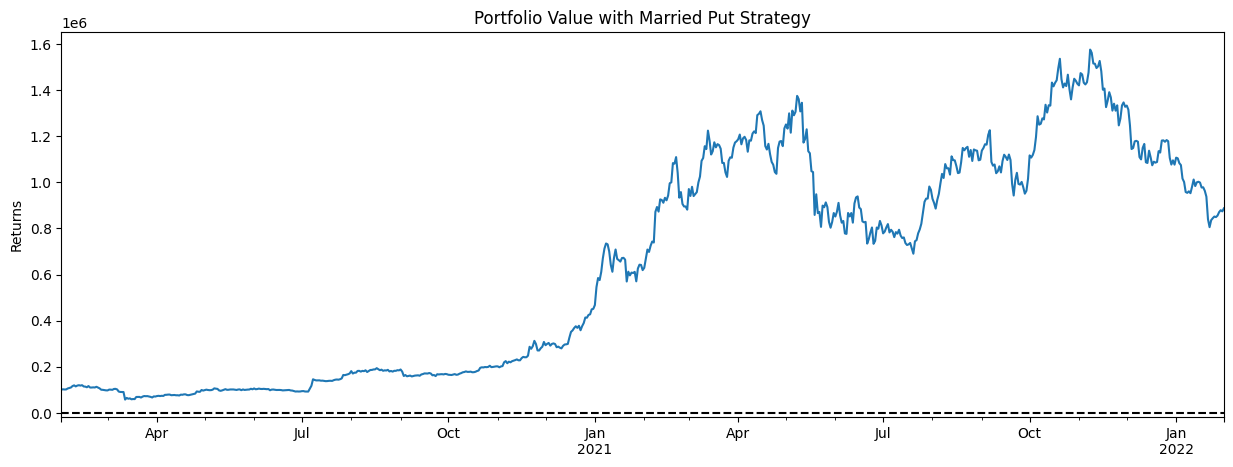

In [55]:
marput_df['Portfolio_value'].plot(figsize = (15, 5))
plt.title(f"Portfolio Value with Married Put Strategy")
plt.ylabel("Returns")
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

In [56]:
marput_df['Portfolio_value'].iloc[-1] - no_limit_df['Portfolio_value'].iloc[-1]

5459.051519351662